# **Overfitting comparison between the two models**

## **Preliminary steps**

In [1]:
### PACKAGES

import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
### FUNCTIONS AND CLASSES

from src.libs import preprocessing, visualization
from src.libs.tokenizer import CharacterLevelTokenizer, ReversedPairingTokenizer
from src.model.bayes_transformer import BayesFormer
from src.model.transformer import Transformer

In [3]:
### DEVICE

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")


Using device: cpu


In [4]:
### SAVING PATH

SAVING_PATH = os.path.join("output", "overfitting")


## **Tokenizer**

In [5]:
### CREATE TOKENIZER

tokenizer = CharacterLevelTokenizer()
tokenizer = ReversedPairingTokenizer()
VOCAB_SIZE = tokenizer.ntokens
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 114


## **Data**

In [6]:
### CONSTANTS

NUM_DIGITS = 3
TRAIN_SIZE = 600
VALID_SIZE = 100
TEST_SIZE = 1000


In [7]:
### CREATE DATASETS

train_dataset = preprocessing.create_dataset(
    nb_samples=TRAIN_SIZE, num_digits=NUM_DIGITS
)
valid_dataset = preprocessing.create_dataset(
    nb_samples=VALID_SIZE, num_digits=NUM_DIGITS
)
test_dataset = preprocessing.create_dataset(
    nb_samples=TEST_SIZE, num_digits=NUM_DIGITS
)

## **MODELS**

In [8]:
### ARCHITECTURE
NB_LAYERS = 2
NB_HEADS = 8
EMBEDDING_DIMENSION = 64
HEAD_SIZE = 8  # EMBEDDING_DIMENSION // NB_HEADS
CONTEXT_LENGTH = 20
HIDDEN_DIMENSION = 8
DROPOUT_TRANSFORMER = 0.1
DROPOUT_BAYESFORMER = 0.3


In [9]:
from src.model.attention_modified import MyTransformer


# Hyperparams
ntoken = VOCAB_SIZE  # taille du vocab
d_model = 64
nheads = 8
dim_ff = 128
nlayers = 2
dropout = 0.1

device = "cpu"
transformer = MyTransformer(
    ntoken, d_model, nheads, dim_ff, nlayers, DROPOUT_TRANSFORMER
).to(device)

bayesformer = MyTransformer(
    ntoken,
    d_model,
    nheads,
    dim_ff,
    nlayers,
    DROPOUT_BAYESFORMER,
    bayes_dropout=DROPOUT_BAYESFORMER,
    bayes=True,
).to(device)
print(
    "number of parameters: {}".format(
        sum([x.numel() for x in transformer.parameters()])
    )
)
print(
    "number of parameters: {}".format(
        sum([x.numel() for x in bayesformer.parameters()])
    )
)


number of parameters: 81138
number of parameters: 81138


In [10]:
### GENERATION FUNCTION


def generate(
    model: Transformer | BayesFormer,
    prompts: torch.Tensor,
    new_tokens: int,
    mode: str = "greedy",
    num_samples: int = 1,
    temperature: float = 0.8,
):
    input_tensor = torch.repeat_interleave(
        prompts, repeats=num_samples, dim=1
    ).to(DEVICE)
    # (prompt_length, batch_size * num_samples)
    for _ in range(new_tokens):
        # output, _ = model(input_tensor)
        output = model(input_tensor)
        logits = output[-1, :, :]  # (batch_size * num_samples, ntokens)
        if mode == "greedy":
            tokens = torch.argmax(logits, -1).view(
                (1, -1)
            )  # (1, batch_size * num_samples)
        else:  # mode == "sampling"
            logits /= temperature
            probs = torch.softmax(logits, dim=-1)
            tokens = torch.multinomial(probs, num_samples=1).view(
                (1, -1)
            )  # (1, batch_size * num_samples)
        input_tensor = torch.cat((input_tensor, tokens), 0)
    return input_tensor


In [11]:
### EVALUATION FUNCTION


def evaluate(
    model: Transformer | BayesFormer,
    dataset: list[tuple[str, str]],
    eval_mode=True,
):
    # Turn on evaluation mode disables dropout.
    if eval_mode:
        model.eval()

    correct = 0.0
    with torch.no_grad():
        for batch, i in enumerate(range(0, len(dataset) - 1, BATCH_SIZE)):
            prompts, target_answers, prompt_length, answers_length, _, _ = (
                preprocessing.get_batch(dataset, tokenizer, i, BATCH_SIZE)
            )
            prompts = prompts.to(DEVICE)  # (prompt_length, batch_size)
            target_answers = target_answers.to(
                DEVICE
            )  # (answers_length + 1, batch_size)
            output = generate(
                model, prompts, answers_length + 1
            )  # (prompt_length + answers_length + 1, batch_size)
            answers_tokens = output[
                prompt_length:, :
            ]  # (answers_length + 1, batch_size), contains tokens
            equality_test = (
                answers_tokens == target_answers
            )  # (answers_length + 1, batch_size), contains boolean values
            correct += torch.all(equality_test, axis=0).float().sum()
        accuracy = correct / len(dataset)
    return accuracy.item()


## **TRAINING**

In [12]:
### CONSTANTS

NB_EPOCHS = 100
BATCH_SIZE = 20
LEARNING_RATE = 1e-3

assert (
    TRAIN_SIZE % BATCH_SIZE == 0
    and VALID_SIZE % BATCH_SIZE == 0
    and TEST_SIZE % BATCH_SIZE == 0
), "BATCH_SIZE must be a divisor of TRAIN_SIZE, VALID_SIZE and TEST_SIZE"


In [13]:
### TRAINING FUNCTION


def train(
    model: Transformer | BayesFormer,
    model_name: str,
    train_dataset: list[tuple[str, str]],
    valid_dataset: list[tuple[str, str]],
    eval_mode: bool,
) -> None:
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    valid_losses = []
    best_valid_loss = float("inf")
    for epoch in range(1, NB_EPOCHS + 1):
        train_loss = 0.0
        valid_loss = 0.0
        # Training
        model.train()
        for batch_train, i in enumerate(
            range(0, len(train_dataset) - 1, BATCH_SIZE)
        ):
            # print(batch_train)
            prompts, target_answers, prompt_length, answers_length, _, _ = (
                preprocessing.get_batch(
                    dataset=train_dataset,
                    tokenizer=tokenizer,
                    i=i,
                    batch_size=BATCH_SIZE,
                )
            )
            prompts = prompts.to(DEVICE)  # (prompt_length, batch_size)
            target_answers = target_answers.to(
                DEVICE
            )  # (answers_length + 1, batch_size)
            input_tensor = torch.cat(
                (prompts, target_answers), 0
            )  # (prompt_length + answers_length + 1, batch_size)
            # output, _ = model(input_tensor)
            optimizer.zero_grad()
            output = model(input_tensor)
            # print(output.shape)
            output_answers = output[prompt_length - 1 : -1, :, :].reshape(
                -1, VOCAB_SIZE
            )  # ((answers_length + 1) * batch_size, vocab_size)
            target_answers = target_answers.view(-1)  # .long()
            loss = criterion(output_answers, target_answers)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                if eval_mode:
                    model.eval()
                output = model(input_tensor)
                # print(output.shape)
                output_answers = output[prompt_length - 1 : -1, :, :].reshape(
                    -1, VOCAB_SIZE
                )  # ((answers_length + 1) * batch_size, vocab_size)
                target_answers = target_answers.view(-1)  # .long()
                train_loss += loss.item()
                loss = criterion(output_answers, target_answers)
                # model.train()
        # Validation
        if eval_mode:
            model.eval()

        # print(output_answers.shape)

        with torch.no_grad():
            for batch_valid, i in enumerate(
                range(0, len(valid_dataset) - 1, BATCH_SIZE)
            ):
                # print(batch_valid)
                prompts, target_answers, prompt_length, answers_length, _, _ = (
                    preprocessing.get_batch(
                        dataset=valid_dataset,
                        tokenizer=tokenizer,
                        i=i,
                        batch_size=BATCH_SIZE,
                    )
                )
                prompts = prompts.to(DEVICE)  # (prompt_length, batch_size)
                target_answers = target_answers.to(
                    DEVICE
                )  # (answers_length + 1, batch_size)
                input_tensor = torch.cat(
                    (prompts, target_answers), 0
                )  # (prompt_length + answers_length + 1, batch_size)
                # output, _ = model(input_tensor)
                # print(input_tensor.shape)
                output = model(input_tensor)
                # print(output.shape)
                output_answers = output[prompt_length - 1 : -1, :, :].reshape(
                    -1, VOCAB_SIZE
                )
                target_answers = target_answers.view(-1).long()
                loss = criterion(output_answers, target_answers)
                valid_loss += loss.item()

        # print(len(train_dataset), len(test_dataset), output_answers.shape)
        # print(batch_train, batch_valid)
        train_loss = train_loss / len(train_dataset)
        valid_loss = valid_loss / len(valid_dataset)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        print(
            f"EPOCH [{epoch} / {NB_EPOCHS}] ----------- TRAIN LOSS : {train_loss:.4f}, VALID LOSS : {valid_loss:4f}"
        )
        accuracy_test_transformer = evaluate(
            model=model, dataset=test_dataset, eval_mode=eval_mode
        )
        print(
            f"Transformer accuracy on test set: {accuracy_test_transformer:.2f}"
        )

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(
                model.state_dict(),
                os.path.join(SAVING_PATH, model_name + ".pt"),
            )

        model.eval()

        # for i in range(5):
        #     prompt, answers = test_dataset[i]
        #     prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1, 1))
        #     output = generate(transformer, prompt_tensor, len(answers)).view(
        #         (1, -1)
        #     )
        #     print(output)
        # print(
        #     tokenizer.decode(output.tolist()[0])
        #     + "\t actual result: "
        #     + answers
        # )
    return np.array(train_losses), np.array(valid_losses)


In [14]:
### TRAIN TRANSFORMER

train_losses_transformer, valid_losses_transformer = train(
    model=transformer,
    model_name="transformer",
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    eval_mode=True,
)


EPOCH [1 / 100] ----------- TRAIN LOSS : 0.1539, VALID LOSS : 0.102187
Transformer accuracy on test set: 0.00
EPOCH [2 / 100] ----------- TRAIN LOSS : 0.0917, VALID LOSS : 0.082700
Transformer accuracy on test set: 0.00
EPOCH [3 / 100] ----------- TRAIN LOSS : 0.0787, VALID LOSS : 0.077560
Transformer accuracy on test set: 0.00
EPOCH [4 / 100] ----------- TRAIN LOSS : 0.0735, VALID LOSS : 0.073048
Transformer accuracy on test set: 0.00
EPOCH [5 / 100] ----------- TRAIN LOSS : 0.0690, VALID LOSS : 0.067846
Transformer accuracy on test set: 0.01
EPOCH [6 / 100] ----------- TRAIN LOSS : 0.0621, VALID LOSS : 0.062416
Transformer accuracy on test set: 0.01
EPOCH [7 / 100] ----------- TRAIN LOSS : 0.0523, VALID LOSS : 0.052529
Transformer accuracy on test set: 0.05
EPOCH [8 / 100] ----------- TRAIN LOSS : 0.0396, VALID LOSS : 0.043549
Transformer accuracy on test set: 0.10
EPOCH [9 / 100] ----------- TRAIN LOSS : 0.0298, VALID LOSS : 0.034474
Transformer accuracy on test set: 0.16
EPOCH [10 

In [15]:
### TRAIN BAYESFORMER

train_losses_bayesformer, valid_losses_bayesformer = train(
    model=bayesformer,
    model_name="bayesformer",
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    eval_mode=True,
)


EPOCH [1 / 100] ----------- TRAIN LOSS : 0.1731, VALID LOSS : 0.119337
Transformer accuracy on test set: 0.00
EPOCH [2 / 100] ----------- TRAIN LOSS : 0.1083, VALID LOSS : 0.099358
Transformer accuracy on test set: 0.00
EPOCH [3 / 100] ----------- TRAIN LOSS : 0.0944, VALID LOSS : 0.091628
Transformer accuracy on test set: 0.00
EPOCH [4 / 100] ----------- TRAIN LOSS : 0.0875, VALID LOSS : 0.086793
Transformer accuracy on test set: 0.00
EPOCH [5 / 100] ----------- TRAIN LOSS : 0.0853, VALID LOSS : 0.083026
Transformer accuracy on test set: 0.00
EPOCH [6 / 100] ----------- TRAIN LOSS : 0.0830, VALID LOSS : 0.083038
Transformer accuracy on test set: 0.00
EPOCH [7 / 100] ----------- TRAIN LOSS : 0.0803, VALID LOSS : 0.077700
Transformer accuracy on test set: 0.00
EPOCH [8 / 100] ----------- TRAIN LOSS : 0.0782, VALID LOSS : 0.079309
Transformer accuracy on test set: 0.00
EPOCH [9 / 100] ----------- TRAIN LOSS : 0.0777, VALID LOSS : 0.076406
Transformer accuracy on test set: 0.00
EPOCH [10 

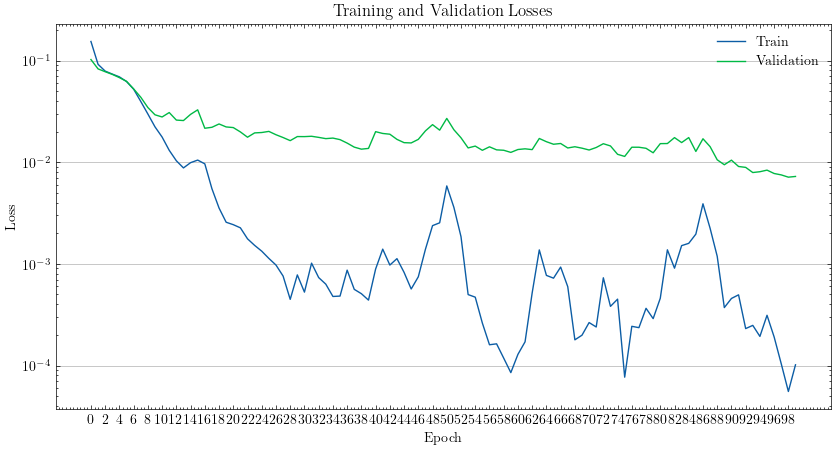

In [16]:
### PLOT TRANSFORMER LOSSES

visualization.plot_losses(
    train_losses=train_losses_transformer,
    valid_losses=valid_losses_transformer,
    ylog=True,
)


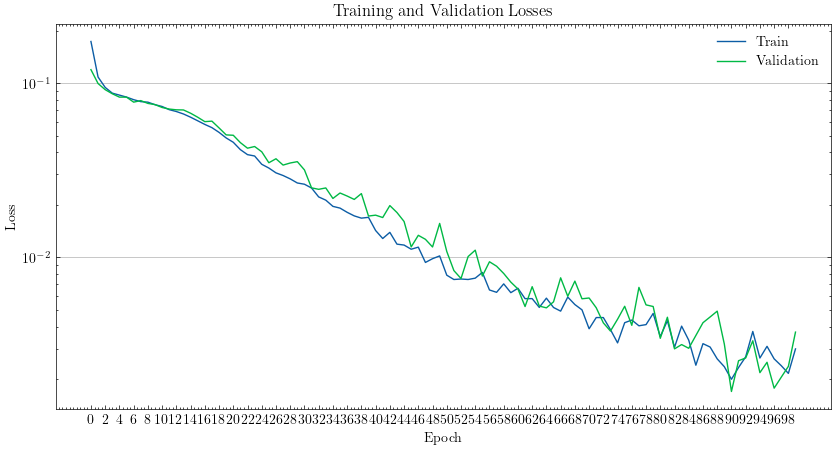

In [17]:
### PLOT BAYESFORMER LOSSES

visualization.plot_losses(
    train_losses=train_losses_bayesformer,
    valid_losses=valid_losses_bayesformer,
    ylog=True,
)


## **Evaluation**

In [18]:
### EVALUATE TRANSFORMER

accuracy_test_transformer = evaluate(model=transformer, dataset=test_dataset)
print(f"Transformer accuracy on test set: {accuracy_test_transformer:.2f}")

### EXAMPLES

transformer.eval()

for i in range(5):
    prompt, answers = test_dataset[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1, 1))
    output = generate(transformer, prompt_tensor, len(answers)).view((1, -1))

    print(tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers)


Transformer accuracy on test set: 0.81
891+347=1238	 actual result: 1238
159+553=712	 actual result: 712
728+866=1594	 actual result: 1594
890+319=1209	 actual result: 1209
885+190=1075	 actual result: 1075


In [19]:
transformer.eval()

for i in range(20):
    prompt, answers = test_dataset[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1, 1))
    output = generate(transformer, prompt_tensor, len(answers)).view((1, -1))

    print(tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers)


891+347=1238	 actual result: 1238
159+553=712	 actual result: 712
728+866=1594	 actual result: 1594
890+319=1209	 actual result: 1209
885+190=1075	 actual result: 1075
984+46=1030	 actual result: 1030
494+571=1065	 actual result: 1065
45+827=862	 actual result: 872
408+778=1186	 actual result: 1186
764+448=1212	 actual result: 1212
839+188=1017	 actual result: 1027
155+818=973	 actual result: 973
240+484=624	 actual result: 724
781+724=1505	 actual result: 1505
299+312=611	 actual result: 611
612+562=1174	 actual result: 1174
482+442=924	 actual result: 924
442+788=1230	 actual result: 1230
75+529=604	 actual result: 604
120+417=537	 actual result: 537
